## Exercise: 
## Subspace-constrained Reconstruction for Inversion-prepared T1 Mapping in BART

This exercise uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and challenges you to apply the previously presented subspace-constrained reconstruction for inversion-prepared T1 Mapping using BART.

**Main Reference**

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. Physics-based reconstruction methods for magnetic resonance imaging. accepted to Philos. Trans. R. Soc. A. arXiv:2010.01403.

**Authors**: [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de), [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

### Prerequisites

Make sure the BART configuration is completed and these paths are set correctly.

`TOOLBOX_PATH=/Your/path/to/bart`

`PATH=$TOOLBOX_PATH:$PATH`

Now, we need the visualization functions already defined in the main tutorials.

In [52]:
echo "BART version"

bart version

# BASH function to write BART file to png,
# display the png, and then remove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow

function imshow_colormap () {
    python3 python/save_maps.py $1 viridis 0 2.0 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow_colormap

# BASH function to visualize timesteps of BART cfl file
function show_timesteps () {

    data=$1
    shift
    pos=("$@")

    ind=0

    for t in "${pos[@]}"
    do
       bart slice 5 $t $data _slice$ind
       ind=$((ind+1))
    done

    bart join 6 `seq -f "_slice%g" 0 $((ind-1))` _slices
    
    DIM=`bart show -d 0 _slices`

    bart reshape $(bart bitmask 1 6) $((DIM*ind)) 1 {_,}slices

    imshow slices
}
export -f show_timesteps

BART version
v0.7.00


### Download Dataset

Many publications using the BART toolbox provide tutorials, code and data. Check out the [BART homepage](https://mrirecon.github.io/bart/) for further details.
Here, we make use one of the published datasets and download an inversion-recovery FLASH one already converted to a *.cfl* and *.hdr* file.

In [2]:
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr

Let us check the dimensions of the dataset by printing out the first two lines of the provided *.hdr* file.

In [3]:
head -n2 IR-FLASH.hdr

# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


Following the dimensionality definitions in BART, we can read out and store the information about the acquisition for later use in the processing and reconstruction.

In [4]:
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
BR=$((READ/2))

### Dictionary Generation, SVD and Temporal Basis

The exercise starts by creating the dictionary. 

First, we specify the sequence characteristics necessary for the simulation of the signal curves.

In [5]:
# Define Sequence Characteristics
TR=0.0041 # [s]
REP=$TIME

# Dictionary characteristics
## R1s
NUM_R1S=1000
MIN_R1S=5e-3
MAX_R1S=5

## Mss
NUM_MSS=100
MIN_MSS=1e-2
MAX_MSS=1

Use the `signal` tool in BART to simulate an analytical **inversion-prepared FLASH** signal by passing the `-F` and `-I` flag. Pass the number of **repetitions** with `-n` and the **repetition time** with `-r`. 

Pass the desired number of $R_1^*$ values with their minimum and maximum values exploiting the `-1 min:max:N` flag and repeat the same for $M_{ss}$ and the `-3 min:max:N` flag.

In [6]:
# Simulate dictionary based on the `signal` tool
bart signal -F -I -n$REP -r$TR \
            -1 $MIN_R1S:$MAX_R1S:$NUM_R1S \
            -3 $MIN_MSS:$MAX_MSS:$NUM_MSS  dicc

Have a look at the dimensions of the created dictionary by printing the corresponding *.hdr* file or using BARTs `show` tool.

In [7]:
# Print dimensions of created dictionary
head -n2 dicc.hdr

# Dimensions
1 1 1 1 1 1020 1000 100 1 1 1 1 1 1 1 1 


The range of simulated $R_1^*$ values is stored in the 6th (coeff1) dimension while the $M_{ss}$ values are in the 7th (coeff2) dimension.

To process the dictionary all elements need to be stored in the 6th dimension. Therefore, use the `reshape` command to concentrate all simulated signals in the coeff1 dimension.

In [8]:
# reshape the dicc 6th and 7th dimension to have all the elements 
# concentrated in the 6th dimension
bart reshape $(bart bitmask 6 7) $((NUM_R1S * NUM_MSS)) 1 dicc dicc_reshape

Print the dimensions of the reshaped dictionary.

In [9]:
# Print the dimensions of the reshaped dictionary
head -n2 dicc_reshape.hdr

# Dimensions
1 1 1 1 1 1020 100000 1 1 1 1 1 1 1 1 1 


Now squeeze all non-zero dimensions with the `squeeze` command and check you progress by printing the dimensions again.

In [10]:
# squeeze the reshaped dictionary to remove non-zero dimensions
bart squeeze dicc_reshape dicc_squeeze

Perform an SVD on the squeezed dictionary with the `svd` command. Specify to perform an economy-size decomposition by adding the `-e` flag.

In [11]:
# Perform an SVD of the squeezed dictionary and output and
# economy-size decomposition of the resulting matrix
bart svd -e dicc_squeeze U S V

Now we can create the temporal basis by extracting the desired number of coefficients from the columns in the 1st dimension of $U$.

In [12]:
# Define number of desired temporal basis coefficients
NUM_COE=4

# Extract desired number of orthonormal columns from U
bart extract 1 0 $NUM_COE U basis

# Print the basis dimensions
head -n2 basis.hdr

# Dimensions
1020 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 


As you might have seen in the dimensions of our createed basis, the coefficients are currently in the 1st and the time is in the 0th dimension.

For compatibility with BART we need to move the dimensions to their natural position within the 16 dimensions of a *.cfl* file:

    time          -> 5th (echo time) dimension
    coeffiecients -> 6th (coeff1) dimension.


In [13]:
# transpose the basis to have time in the 5th dimension 
# and coefficients in the 6th dimension
bart transpose 1 6 basis basis1
bart transpose 0 5 basis1 basis_$NUM_COE

# Print the transposed basis dimensions
head -n2 basis_$NUM_COE.hdr

# Dimensions
1 1 1 1 1 1020 4 1 1 1 1 1 1 1 1 1 


### Coil Compression, Generate Golden-Angle-based Radial Trajectory and Gradient Delay Correction 

Print the dimensions of the previously downloaded dataset.

In [14]:
head -n2 IR-FLASH.hdr

# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


Because the non-Cartesian data handling expects cooridnate positions in the 0th dimension and samples in the first dimension, we need to transpose the 0th and 1st dimension with the `transpose` command.

In [17]:
# Transpose the 0th and 1st dimension of the downloaded data
# to ensure compatibility with BARTs non-Cartesian tools
bart transpose 0 1 IR-FLASH ksp

# Print dimensions
head -n2 ksp.hdr

# Dimensions
1 512 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


#### Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command. By passing `-A` we choose to use all possible data and want to reduce the dataset to *NUM_VCOILS* virtual coils with `-p`.

In [18]:
NUM_VCOILS=8

# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


#### Generate the Trajectory
In the next step we generate a trajectory with the `traj` tool. To match the acquisition of the downloaded data, we need to specify a radial `-r`, centered `-c`, double-angle `-D`, 7th tiny golden-angle `-G -s7` sampling. The timesteps are passed using `-t`, the spokes by `-y` and the samples are specified with `-x`.

In [19]:
NUM_TGA=7

# Create the trajectory using the `traj` tool
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -t$REP traj

# Print out its dimensions
head -n2 traj.hdr

# Dimensions
3 512 1 1 1 1 1 1 1 1 1020 1 1 1 1 1 


Here the 3 in the zeroth dimensions includes the coordinates in (x,y,z) and is the reasion for the previous transpose of the downloaded dataset!


#### Gradient Delay Correction
Because the dataset is following an IR FLASH signal relaxation, the gradient delay correction should be applied to data in the last repetitions which are in a steady-state. Therefore, we extract some final repetitions from the trajectory and the dataset using the `extract` command. Have in mind that the time dimension is the 10th here!

In [20]:
# Define the number of timesteps for gradient delay correction
FRAMES_FOR_GDC=100

# Extract the DATA_GDC last time frames from the trajectory and the dataset
bart extract 10 $((REP-FRAMES_FOR_GDC)) $REP traj traj_extract
bart extract 10 $((REP-FRAMES_FOR_GDC)) $REP ksp_cc ksp_extract

The gradient delay tool `estdelay` only estimates delays between spokes and does not support a time dimension. Assuming that all extracted spokes were acquired during the steady-state, all extracted timesteps can be transposed into the 2nd dimension for spokes (phase2) using the `transpose` command.

In [21]:
# Transpose the 2nd and 10th dimension for later use with the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

Afterwards the gradient delays can be estimated using the `estdelay` tool. It is recommended to use the RING technique by adding the `-R` flag.

In [22]:
# Estimate and store the gradient delays usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

Gradient Delays: -0.120594:0.161871:0.009425


To correct the trajectory by this delay, we use the same `traj` command call as before, but pass the known delays with the `-q`.

In [23]:
# Calculate the trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -t$REP -q $GDELAY trajn

If you do not want to run the trajectory creation, the following cell will load the precomputed ouput.

In [46]:
# Load precomputed results if necessary
[ ! -f "trajn.cfl" ] && bart copy ref/trajn_precomp trajn

### Coil Sensitivity Estimation

The coil profile estimation is similar to the gradient delay estimation performed on some of the last timesteps of the IR FLASH dataset. Therefore, *FRAMES_FOR_CSE* spokes from the last timesteps are extracted using the `extract` command.

In [25]:
FRAMES_FOR_CSE=300

# Extract last time frames (10th dim) from trajectory and k-space data
bart extract 10 $((REP-FRAMES_FOR_CSE)) $REP trajn traj_ss
bart extract 10 $((REP-FRAMES_FOR_CSE)) $REP ksp_cc ksp_cc_ss

By assuming all extracted frames to be acquired during the steady-state, we again can transpose the 10th dimension (time) with the spoke dimension (2nd/phase2).

In [26]:
bart transpose 2 10 traj_ss traj_ss2
bart transpose 2 10 ksp_cc_ss ksp_cc_ss2

For the coil profile estimation we want to use **ESPIRiT**. Because its BART implementation `ecalib` requires Cartesian k-space data, we need to grid our radial data first.

A handy solution in BART exploits the gridding step during an nuFFT call. So we start with performing an inverse `nufft` on our extracted steady-state data. Constrain the output dimension using the `-d` flag to the readout samples.

In [27]:
# apply an inverse nufft of the extracted steady-state dataset
bart nufft -i -d$READ:$READ:1 traj_ss2 ksp_cc_ss2 img

Done.


The resulting reconstruction can now be transformed back into the frequency domain with an unitary (`-u`) Fourier tranformation with the `fft` command.

In [28]:
# transform reconstruction in image space back to k-space
# to create gridded k-space for the ESPIRiT implementation
bart fft -u $(bart bitmask 0 1 2) img ksp_grid

Finally, use BARTs ESPIRiT implementation `ecalib` to estimate the coil sensitivities from the gridded k-space. We recommend using a threshold `-t`, just one ESPIRit map `-m` and smooth map transitions `-S`

In [29]:
THRESHOLD=0.01
NUM_ESPIRIT_MAP=1

# Estimate coil sensitivities from gridded, steady-state k-space using `ecalib`
bart ecalib -S -t $THRESHOLD -m $NUM_ESPIRIT_MAP ksp_grid sens_invivo

Done.


If you do not want to run the coil sensitivity estimation, the following line will load the precomputed sensitivities.

In [47]:
# Load precomputed results if necessary
[ ! -f "sens_invivo.cfl" ] && bart copy ref/sens_invivo_precomp sens_invivo

### Subspace-Constrained Reconstruction
To start the subspace-constrained reconstruction we need to verify the data and trajectory dimension again.

In [32]:
echo "Trajectory:"
head -n2 trajn.hdr

echo "Data:"
head -n2 ksp_cc.hdr

Trajectory:
# Dimensions
3 512 1 1 1 1 1 1 1 1 1020 1 1 1 1 1 
Data:
# Dimensions
1 512 1 8 1 1 1 1 1 1 1020 1 1 1 1 1 


The `pics` tool in BART requires all timesteps to be in the 5th (echo) dimension. Use the `reshape` or `transpose` command to do this.

In [33]:
bart transpose 5 10 trajn traj_final
bart transpose 5 10 ksp_cc ksp_final

Now, we can perform the subspace-constrained reconstruction with BARTs **P**arallel **I**maging **C**ompressed **S**ensing tool: `pics`.

We recommend scaling on maximum eigenvalues `-e` and $l_1$-wavelet regularization `-R W:A:B:C `in the image dimensions (A) and jointly (B) on the basis coefficients. You also might use a debugg value `-d` and pass a previously defined number of iterations `-i`.

Most important for a subspace-constrained reconstruction is to pass the temporal basis with `-B`.

In [34]:
DEBUG=4
ITER=100
REG=0.0015

bart pics   -e -d $DEBUG -i$ITER \
            -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG \
            -t traj_final -B basis_$NUM_COE \
            ksp_final sens_invivo subspace_reco_invivo

Basis: [512 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
Max:   [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
[  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
[512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1020   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1 1020 ]
nufft psf dims:    [1024 1024   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 1020 ]
Allocating 8355840 (vs. 16785408) + 1677

If you do not want to run the time consuming reconstruction, the following cell will load the precomputed results.

In [48]:
# Load precomputed results if necessary
[ ! -f "subspace_reco_invivo.cfl" ] && \
bart copy ref/subspace_reco_invivo_precomp subspace_reco_invivo

As you can see from the dimensions of the reconstruction

In [37]:
# Print dimensions of reconstruction
head -n2 subspace_reco_invivo.hdr

# Dimensions
512 512 1 1 1 1 4 1 1 1 1 1 1 1 1 1 


we got a two times larger FOV through the 2-fold oversampling. The images can be resized to the desired base resolution *BR* using the `resize` command. Ensure to use a centered crop `-c` of the first two dimensions.

In [38]:
# Resize reconstructions to remove 2-fold oversampling effects
bart resize -c 0 $BR 1 $BR subspace_reco_invivo coeff_maps

Now we can visualize the reconstructed maps.

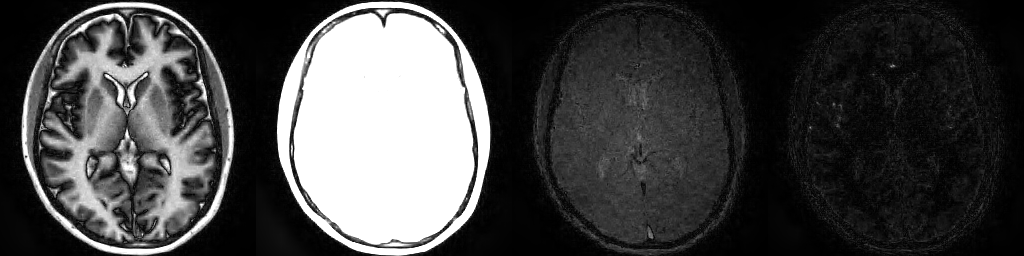

In [39]:
# Reshape and flip coefficient maps for improved visualization

## Concentrate all coefficients in the column dimension (1st/phase1)
bart reshape $(bart bitmask 1 6) $((BR*NUM_COE)) 1 coeff_maps subspace_maps

## Flip the map in row dimension to have the forhead pointing to the top of the page
bart flip $(bart bitmask 0) subspace_maps subspace_maps1

imshow subspace_maps1

### Projection to Time Series and T1 Map Estimation

The reconstructed maps are in a subspace. To obtain the full time series from these coefficients we multiply the coefficient maps with the previously estimated basis using `fmac`. After summing the result using the `-s` flag in the coefficient dimension, we have recovered a full time series from the subspace coefficients.

In [40]:
# Multiply the reconstructed coeff maps with the optained time basis
# Squash the coeffiencient dimension (6) to sum all coeff timeseries up
bart fmac -s $(bart bitmask 6) basis_$NUM_COE coeff_maps time_series

# Print dimensions of time series
head -n2 time_series.hdr

# Dimensions
256 256 1 1 1 1020 1 1 1 1 1 1 1 1 1 1 


Next, we visualize some exemplaric steps of the time series.

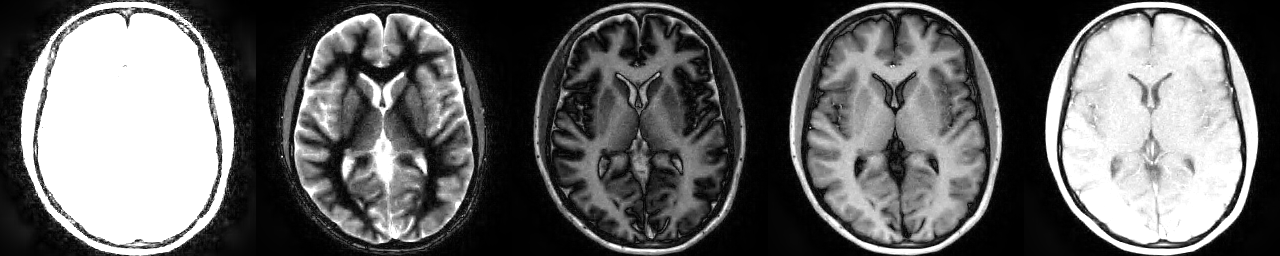

In [41]:
# Flip the datas row dimension again to have the forehead pointing up
bart flip $(bart bitmask 0) time_series time_series1

# Visualize some exemplaric timesteps
t=( 0, 100, 200, 300, 900 )
show_timesteps time_series1 "${t[@]}"

To estimate T1 maps from these timesteps we will perform a pixelwise fitting using the pyhton script provided in *mapping_piecewise.py*.

In [59]:
# Perform a pixelwise fitting of the time series to obtain the T1 maps
MTR=4100 #TR in [us]
M0_THRESHOLD=0.1
DELAY=15.3e-3

## Prepare time vector
### Create vector from 0 to REP
bart index 5 $REP tmp1
### Multiply vector with TR in [us]
bart scale $MTR tmp1 tmp2
### Scale time vector from [us] to [s]
bart scale 0.000001 tmp2 TI
    
# Perform pixelwise fitting
python3 python/mapping_piecewise.py time_series1 T1 TI maps

# Extract first three maps (Mss, M0, R1s)...
bart extract 2 0 3 maps tmp1
# ... and move them to the coeff dimension
bart transpose 2 6 tmp1 tmp2

# Estimate T1 from (Mss, M0, R1s)
bart looklocker -t $M0_THRESHOLD -D $DELAY tmp2 tmp3

# Correct T1 for reconstruction scaling factor
bart scale 0.5 tmp3 subspace_invivo_T1map

Traceback (most recent call last):
  File "python/mapping_piecewise.py", line 114, in <module>
    mapping_piecewise( sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4] )
  File "python/mapping_piecewise.py", line 91, in __init__
    self.oridata = np.array( cfl.readcfl(self.infile).squeeze() ) #dim = [x, y, time, slice]
  File "/home/nick/bart/python/cfl.py", line 14, in readcfl
    h = open(name + ".hdr", "r")
FileNotFoundError: [Errno 2] No such file or directory: 'time_series1.hdr'
Loading cfl file maps
 : No such file or directory
ERROR: Aborted (core dumped)


If you do not want to run the pixel-wise fitting the following cell will just load the precomputed result.

In [49]:
# Load precomputed results if necessary
[ ! -f "subspace_invivo_T1map.cfl" ] && \
bart copy ref/subspace_invivo_T1map_precomp subspace_invivo_T1map

Fianlly, we can visualize the estimated T1 map.

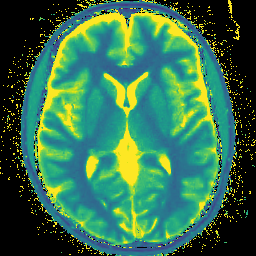

In [57]:
imshow_colormap subspace_invivo_T1map

Thank you for your participation! Feel free to ask any questions:)